## Sensor Positions Optimization Problem

This notebook presents the outcome of the research of our team in Sensor Positions Optimization Problem. Here we show results of classical and quantum algorithms with all intermediate steps of the calculating process.

First, import of needed modules.

In [6]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [7]:
from Modules.Environment import Environment
from Optimization.Classical_algorithms import MaxCov
from Optimization.Quantum_algorithms import QAOA, EstimGState
from braket.aws import AwsDevice
from braket.devices import LocalSimulator
import boto3
%matplotlib notebook

The next step is to choose a device in which the circuit will be run. For presentation, we use LocalSimulator(), but any AWS device with corresponding architecture can be used.

In [8]:
# get the account ID
# aws_account_id = boto3.client("sts").get_caller_identity()["Account"]
# the name of the bucket
# my_bucket = "example-bucket"
# the name of the folder in the bucket
# my_prefix = "simulation-output"
# s3_location = (my_bucket, my_prefix)
# device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
device = LocalSimulator()

Let's start for the classical algorithm. First of all, we must create the instance of Environment class with coresponding parameters.

In [9]:
grid_step = 0.2        # Step of a grid which represent vehicle's surrounding
scenario = 'Parking'   # Scenario of surrounding (pissible scenarios: Parking, EBA, Perpendicular crossing,
                       # Traffic sign recognition, Lane keep, Junction, Highway exit, Highway entry)

# Creating instances of Environment() for cubic and sector regions of interest
Parking_1 = Environment(scenario=scenario, grid_step=grid_step, roi_type='Cubic')
Parking_2 = Environment(scenario=scenario, grid_step=grid_step, roi_type='Sector')

# Combine Environment() instances and set the budget
Parking = Parking_1 + Parking_2
Parking.budget = 150

Now, we can start a classical optimization. For this purpose we create the instance of the MaxCov() class which solve optimozation problem with the greedy algorithm for the Budgeted Max Coverage Problem. On the image above, we can see 3D grid where the colorbar represents a value of the critical index (bright yellow represents sensors).

Greedy algorithm for Max Coverage problem starts...
Algorithm settings: number of horizontal angles: 7, number of vertical angles: 5, list of sensors type: Ultrasound.

Evaluating coverage for all possible positions/orientations for Ultrasound...
Calculating coverage for all possible positions/orientations in Front polygon (1/5)
Time spent 00:01:52.
Calculating coverage for all possible positions/orientations in Front Roof polygon (2/5)
Time spent 00:00:38.
Calculating coverage for all possible positions/orientations in Back polygon (3/5)
Time spent 00:01:29.
Calculating coverage for all possible positions/orientations in Side Left polygon (4/5)
Time spent 00:03:43.
Calculating coverage for all possible positions/orientations in Side Right polygon (5/5)
Time spent 00:03:44.
Time requested by all evaluating 00:11:28.

Environment created by scenario Parking(Cubic), Parking(Sector)
(Budget: 150 $. Grid step: 0.2)
----------------------------List of presents sensors-----------------------

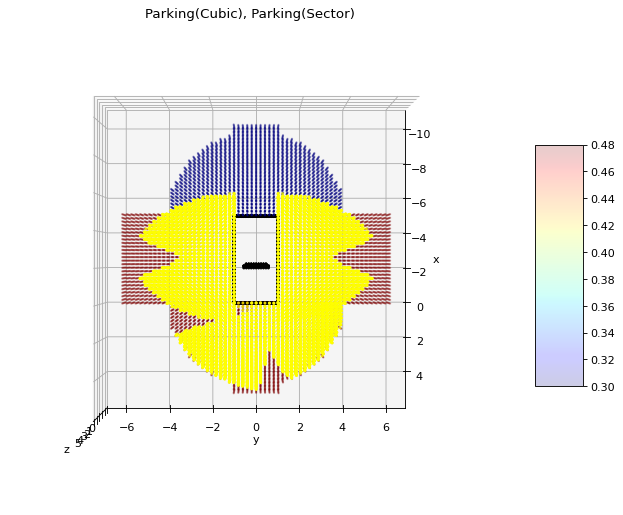

In [5]:
# Parameters of MaxCov():
# env - corresponding Environment() instance
# num_of_phi - number of possible horizontal angles of sensor orientation
# num_of_theta - number of possible vertical angles of sensor orientation
# type_list - list of sensor's type (possible type: Ultrasound, Camera, Radar, and Lidar)
opt_problem = MaxCov(env=Parking, num_of_phi=7, num_of_theta=5, type_list=['Ultrasound'])

# Computing optimization
opt_problem.compute()

The next step, is the quantum algorithm. For the quantum optimization we can use the same Environment. For reducing a search space for the quantum algorithm, we choose optimal possitions, most frequently choosen by classical algorithm. Le'ts initializing the instance of the QAOA() class and run calculation. Note that histograms are built only with bitstrings that have more than five measurements (number of shots for LocalSimulator() - 10000 and for real device - 1000).

Building the Hamiltonian...Done.
Optimization of QAOA parameters Gammas and Betas...Details of optimization: 
      fun: -56.93917501747846
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 40
  status: 1
 success: True
       x: array([1.23785218, 1.        , 2.05446618, 1.53695071])
Done.
Time requested for optimization 00:00:05.
Optimal parameters: [1.23785218 1.         2.05446618 1.53695071]
Depth of circuit 303


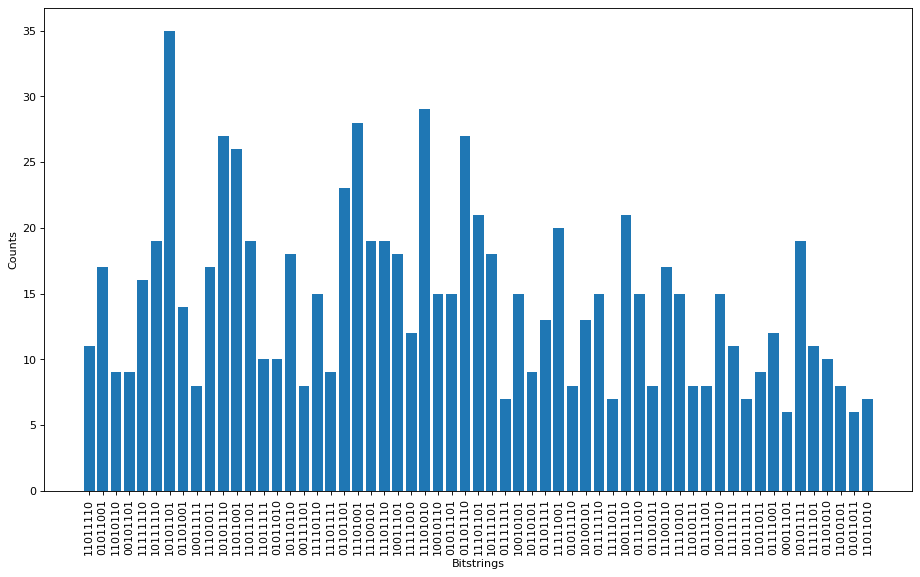

Best solution: 10101101
Environment created by scenario Parking(Cubic), Parking(Sector)
(Budget: 150 $. Grid step: 0.2)
----------------------------List of presents sensors----------------------------
----Sensor type--------Position [x, y, z]----Orientation [phi, theta]-----Price-----
     Ultrasound          [-3.7, -1.0, 1]         [-90.0, 90]               25          
     Ultrasound           [0.0, 0.0, 1]           [0.0, 90]                25          
     Ultrasound          [-3.7, -1.0, 1]         [-30.0, 90]               25          
     Ultrasound          [-3.7, 1.0, 1]           [30.0, 90]               25          
Total cost: 100 $


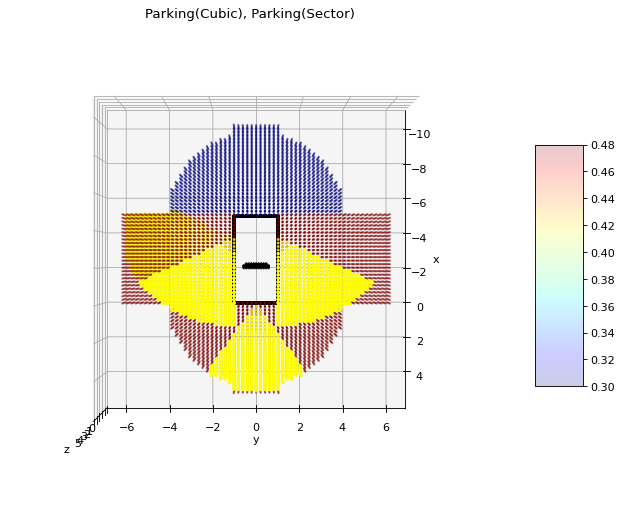

In [5]:
# Choose number of sensors from most frequently choosen
Parking.sensor_setup(4)

# Parameters of QAOA() instance
# environment - corresponding Environment() instance
# num_of_orient - number of possible horizontal angles of sensor orientation
# list_of_types - list of sensor's type (possible type: Ultrasound, Camera, Radar, and Lidar)

opt_problem = QAOA(environment=Parking, num_of_orient=3, list_of_types=['Ultrasound'])

# Computing optimization with parameters
# p - depth of QAOA
# optimizer - classical optimizer for parameters Betas and Gammas ('COBYLA' or 'brute')
# device - parameter for choosing another device
# s3_location - parameter for saving data
opt_problem.compute_qaoa(p=2, optimizer='COBYLA')

Another possibility of investigating our system - it's founding the energy levels of Hamiltonian. Here we present the plot of energy spectrum of Hamiltonian.

<IPython.core.display.Javascript object>


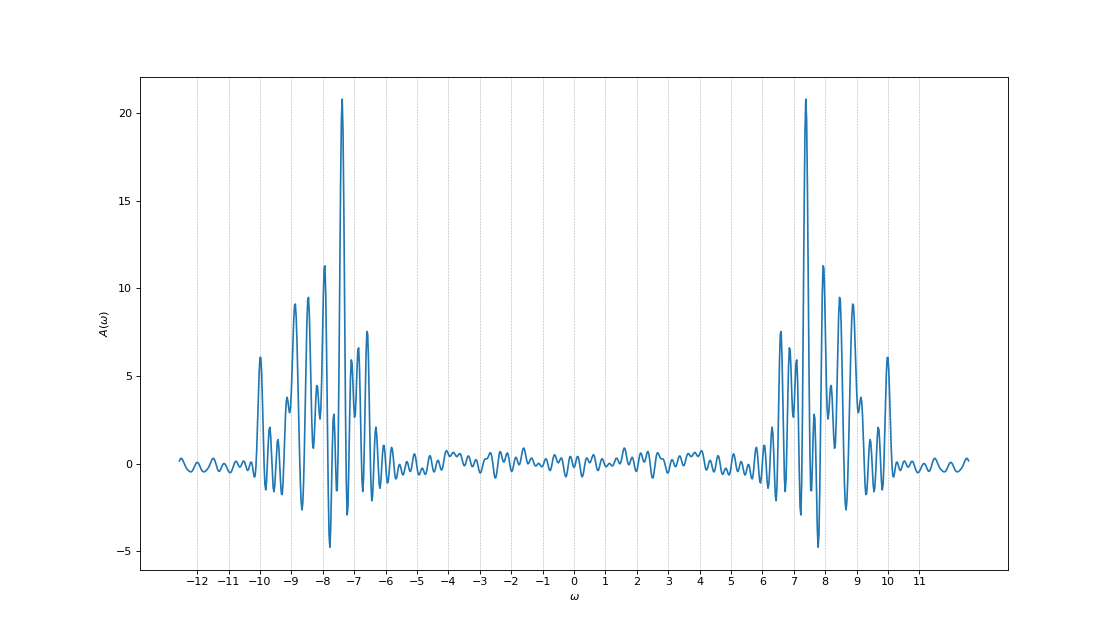

In [10]:
# Choose the number of sensor
Parking.sensor_setup(2)

# Parameters of EstimGState() instance () (child class from QAOA())
# environment - corresponding Environment() instance
# num_of_orient - number of possible horizontal angles of sensor orientation
# list_of_types - list of sensor's type (possible type: Ultrasound, Camera, Radar, and Lidar)
# c - value of constance
# step - step of time coefficients
states = EstimGState(environment=Parking, num_of_orient=3, list_of_types=['Ultrasound'], c=10, step=12)
states.fourier_trans(4)